<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose. This material is a translated version of the Capstone project (by the same author) from specialization "Machine learning and data analysis" by Yandex and MIPT. No solutions shared.

# <center>Week 4.  Classification algorithms comparison

Finally, we are going to train classification models, compare several algorithms via cross-validation, and figure out which session's parameters (*session_length* и *window_size*) it is better to use. Also, for the chosen algorithm, we will plot learning curves (which show the dependecy of model performance on the amount of training data) and validation curves (which show the dependency of model performance on one of it's hyperparameters).

**Week 4 roadmap:**
- Part 1. Different algorithms comparison on sessions of 10 websites
- Part 2. Hyperparameter tuning – session_length and window_size
- Part 3. Particular user identification and learning curves

**You might find following links useful:**
   - [Hyperparameter Optimization in Machine Learning Models](https://www.datacamp.com/community/tutorials/parameter-optimization-machine-learning-models)
   - [Optimizing your model with cross-validation](http://blog.kaggle.com/2015/06/29/scikit-learn-video-7-optimizing-your-model-with-cross-validation/)

**Your task**
1. Fill in code in provided notebook
2. Choose the answers in the [form](https://docs.google.com/forms/d/10kYgawyf9kId7VDOnBhQ6PH64rU2HR0CmTy5CDwy2Vo)

In [1]:
# pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.7.0
IPython 6.5.0

numpy 1.14.5
scipy 1.1.0
pandas 0.23.4
matplotlib 2.2.3
statsmodels 0.9.0
sklearn 0.20.0

compiler   : Clang 6.0 (clang-600.0.57)
system     : Darwin
release    : 17.7.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
Git hash   : 3ec98f89842959c7c200f65f051d89af17ea60e0


In [12]:
import os
import warnings
import itertools
import pickle

import numpy as np
import pandas as pd
import seaborn as sns


from time import time
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix

from __future__ import division, print_function
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV

sns.set()

# disable Anaconda warnings
warnings.filterwarnings('ignore')

In [13]:
# Change the path to data
PATH_TO_DATA = '../../data/capstone_user_identification/'

## Part 1. Different algorithms comparison on sessions of 10 websites

**Load *X_sparse_10users* and *y_10users* objects serialized earlier, which correspond to 10 users data.**

In [5]:
#You might wanna check the `encoding` param if you face any error while opening the .pkl files..
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**There are more than 14 thousand sessions and almost 5 thousand unique websites.**

In [6]:
X_sparse_10users.shape

(14061, 4913)

**Split the data into two parts. We are going to use the first part for cross-validation, second part will be used to evaluate performance of the model that we will end up with after cross-validation.**

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                      random_state=17, stratify=y_10users)

**Define cross-validation: 3-fold, with shuffle, random_state=17 – for reproducibility.**

In [10]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Utility function to plot validation curves after running `GridSearchCV` (or `RandomizedCV`).**

In [11]:
def plot_validation_curves(param_values, grid_cv_results_):
    
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Train `KNeighborsClassifier` with 100 nearest neighbours (leave other parameters default values, only set `n_jobs = -1` for parallelization) and compare model's mean accuracy during 3-fold cross-validation (for reproducibility use `skf` object) on `(X_train, y_train)` and model's accuracy on `(X_valid, y_valid)`.**

In [14]:
from sklearn.neighbors import KNeighborsClassifier

In [15]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)

**<font color='red'>Question 1. </font> Evaluate KNeighborsClassifier's mean accuracy during cross-validation and model's accuracy on the validation dataset. Round your answers up to the third digit after a decimal point. Write your answers with a space between them.**

In [18]:
cross_val_score(knn, X_train, y_train, cv=skf).mean()

0.5647188870063362

In [19]:
knn.fit(X_train, y_train)
accuracy_score(y_valid, knn.predict(X_valid))

0.584024650391088

**2. Train a random forest (`RandomForestClassifier`) consisting of 100 trees (for reproducibility use `random_state`=17). Compare model's OOB-score on and its accuracy on `(X_valid, y_valid)`. Use `n_jobs = -1` for parallelization.**

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [21]:
forest = RandomForestClassifier(n_estimators=100, random_state=17, n_jobs=-1, oob_score=True)

**<font color='red'>Question 2. </font> Evaluate `RandomForestClassifier` Out-of-Bag aka OOB score and its accuracy on the validation dataset. Round your answers up to the third digit after a decimal point. Write your answers with a space between them.**

In [22]:
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=17, verbose=0, warm_start=False)

In [26]:
round(forest.oob_score_, 3)

0.717

In [27]:
round(accuracy_score(y_valid, forest.predict(X_valid)), 3)

0.731

**3. Train logistic regression with default C value and `random_state`=17. Compare model's mean accuracy during 3-fold cross-validation (don't forget to use `skf` object) on `(X_train, y_train)` and model's accuracy on `(X_valid, y_valid)`. Use `n_jobs = -1` for parallelization.**

In [29]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [30]:
logit = LogisticRegression(random_state=17, n_jobs=-1)

In [34]:
round(cross_val_score(logit, X_train, y_train, cv=skf).mean(), 3)

0.761

In [35]:
logit.fit(X_train, y_train)
round(accuracy_score(y_valid, logit.predict(X_valid)), 3)

0.782

**Read the documentation for [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Logistic regression is well studied and there are algorithms for fast parameter `C` search (faster than using `GridSearchCV`).**

**Using `LogisticRegressionCV` find optimal C value. Fisrt try wider range: 10 values from 1e-4 up to 1e2 using `logspace` from `NumPy`. Specify `multi_class`='multinomial' and `random_state`=17 for `LogisticRegressionCV`. For cross-validation use `skf` object created earlier. Use `n_jobs`=-1 for parallelization.**

**Plot validation curves for parameter `C`.**

In [36]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1, multi_class="multinomial", random_state=17, n_jobs=-1)
logit_grid_searcher1.fit(X_train, y_train)

CPU times: user 1.12 s, sys: 108 ms, total: 1.22 s
Wall time: 17.4 s


**Mean accuracy during cross-validation for each of 10 `C` values.**

In [58]:
logit_mean_cv_scores1 = logit_grid_searcher1.scores_[31].mean(axis=0)

**Print the best accuracy on cross-validation and corresponding value of `C`.**

In [65]:
''' YOUR CODE IS HERE '''
logit_mean_cv_scores1.max(), logit_c_values1[logit_mean_cv_scores1.argmax()]

(0.7607199894066068, 1.0)

**Plot Accuracy vs. `C` dependency graph on cross-validation.**

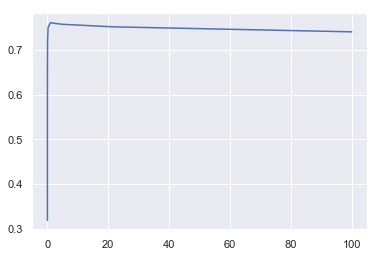

In [66]:
plt.plot(logit_c_values1, logit_mean_cv_scores1);

**Now, do the same again but search `C` values in range `np.linspace`(0.1, 7, 20). Plot the validation curves and find the best accuracy on cross-validation.**

In [67]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2, multi_class="multinomial", random_state=17, n_jobs=-1)
logit_grid_searcher2.fit(X_train, y_train)

CPU times: user 1.31 s, sys: 278 ms, total: 1.59 s
Wall time: 42 s


**Mean accuracy during cross-validation for each of 10 `C` values.**

In [71]:
logit_mean_cv_scores2 = logit_grid_searcher2.scores_[31].mean(axis=0)
logit_mean_cv_scores2

array([0.73684386, 0.75777342, 0.76102512, 0.76061824, 0.76011036,
       0.76041564, 0.76082143, 0.76031379, 0.75878931, 0.75868762,
       0.75817971, 0.7582818 , 0.75828198, 0.75757107, 0.75746919,
       0.75696088, 0.75696088, 0.75645312, 0.75645284, 0.75594486])

**Print the best accuracy on cross-validation and corresponding value of C.**

In [72]:
logit_mean_cv_scores2.max(), logit_c_values2[logit_mean_cv_scores2.argmax()]

(0.7610251150973616, 0.8263157894736842)

**Plot Accuracy vs. `C` dependency graph on cross-validation.**

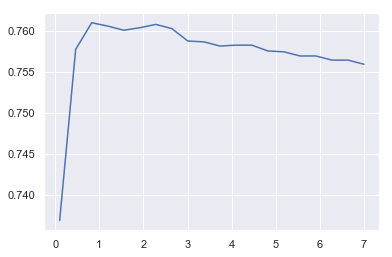

In [73]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

**Print logistic regressoin's accuracy with the best `C` value on `(X_valid, y_valid)`.**

In [76]:
logit_cv_acc = accuracy_score(y_valid, logit_grid_searcher2.predict(X_valid))

**<font color='red'>Question 3. </font> Evaluate model's mean accuracy for `logit_grid_searcher2` on cross-validation using the best `C` and its accuracy on the validation dataset. Round your answers up to the third digit after a decimal point. Write your answers with a space between them.**

In [77]:
''' YOUR CODE IS HERE '''
cross_val_score(logit_grid_searcher2, X_train, y_train, cv=skf)

array([0.75159817, 0.77035682, 0.75320317])

In [81]:
round(np.array([0.75159817, 0.77035682, 0.75320317]).mean(), 3), round(logit_cv_acc, 3)

(0.758, 0.776)

**4. Train SVM (`LinearSVC`) with `C`=1 and `random_state`=17. Compare model's mean accuracy during cross-validation (don't forget to use `skf` object) and model's ccuracy on `(X_valid, y_valid)`.**

In [82]:
from sklearn.svm import LinearSVC

In [83]:
svm = LinearSVC(C=1, random_state=17)

In [85]:
cross_val_score(svm, X_train, y_train, cv=skf).mean()

0.7527977033131527

In [86]:
svm.fit(X_train, y_train)
accuracy_score(y_valid, svm.predict(X_valid))

0.7769613652524295

**Using `GridSearchCV` find optimal C value for SVM. Fisrt try wider range: 10 values from 1e-4 up to 1e2 using `linspace` from NumPy. Plot the validation curves.**

In [87]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, param_grid=svm_params1, n_jobs=-1)
svm_grid_searcher1.fit(X_train, y_train)

CPU times: user 3.65 s, sys: 129 ms, total: 3.78 s
Wall time: 32.5 s


**Print the best accuracy on cross-validation and corresponding value of `C`.**

In [89]:
svm_grid_searcher1.best_params_, svm_grid_searcher1.best_score_

({'C': 5555.555600000001}, 0.6886811623653729)

**Plot Accuracy vs. C dependency graph on cross-validation.**

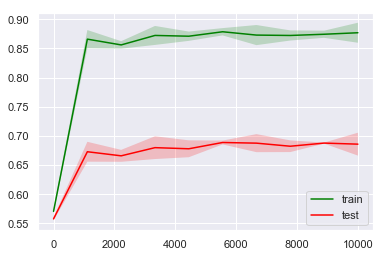

In [90]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**But we remember that using deafault regularization parameter (`C`=1) on cross-validation we get a higher accuracy. That's the case (not rare) of a possibility to make a mistake and searching parameters in a wrong range (the reason is that we took a uniform grid on a large scale and missed optimal interval of `C` values). It is more meaningful to search `C` near 1, in addition, model trains faster than with higher values of `C`.**

**Using `GridSearchCV` find optimal `C` value for SVM in range(1e-3, 1), 30 values, use `linspace` from NumPy. Plt the validation curves.**

In [91]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, param_grid=svm_params2, n_jobs=-1)
svm_grid_searcher2.fit(X_train, y_train)

CPU times: user 965 ms, sys: 157 ms, total: 1.12 s
Wall time: 1min 5s


**Print the best accuracy on cross-validation and corresponding value of `C`.**

In [93]:
svm_grid_searcher2.best_params_, svm_grid_searcher2.best_score_

({'C': 0.13879310344827586}, 0.7661044503149766)

**Plot Accuracy vs. C dependency graph on cross-validation.**

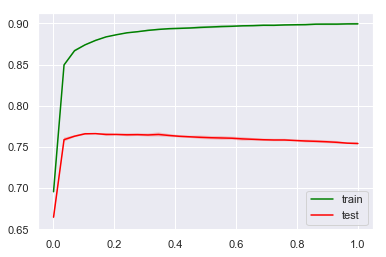

In [94]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

**Print `LinearSVC`'s accuracy with the best `C` value on (X_valid, y_valid).**

In [95]:
svm_cv_acc = accuracy_score(y_valid, svm_grid_searcher2.best_estimator_.predict(X_valid))

In [97]:
round(svm_cv_acc, 3)

0.782

**<font color='red'>Question 4. </font> Evaluate model's mean accuracy for `svm_grid_searcher2` on cross-validation using the best `C` and its accuracy on the validation dataset. Round your answers up to the third digit after a decimal point. Write your answers with a space between them.**

In [98]:
round(cross_val_score(svm_grid_searcher2.best_estimator_, X_train, y_train, cv=skf).mean(), 3)

0.763

## Part 2. Parameter tuning – session_length and window_size

**Let's take `LinearSVC` since it performed best on cross-validation in part 1 and check its performance on 8 datasets of 10 users (with different combiantions of `session_length` and `window_size`). Since there are much more computations, we will not search regularization parameter `C` each time.**

**Write the `model_assessment` function with the specification provided below. Pay your attention to all details, e.g. `train_test_split` should be stratified. Don't forget `random_state` anywhere.**

In [100]:
from copy import copy

In [101]:
def load_obj(path_to_pickle):
    with open(path_to_pickle, "rb") as pickle_file:
        object_ = pickle.load(pickle_file)
        
    return object_

In [139]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    estimator_safe = copy(estimator)
    X = load_obj(path_to_X_pickle)
    y = load_obj(path_to_y_pickle)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, 
                                                          random_state=random_state, stratify=y)
    mean_cross_val = cross_val_score(estimator_safe, X_train, y_train, cv=cv).mean()
    print("cross_val: ", mean_cross_val)
    estimator_safe.fit(X_train, y_train)
    
    return mean_cross_val, accuracy_score(y_valid, estimator_safe.predict(X_valid))

**Double-check that the function is working.**

In [104]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

(0.7633649590115557, 0.7817018250770325)

**Apply `model_assessment` function for the best algorithm from the previous part (namely, `svm_grid_searcher2.best_estimator_`) and 9 datasets with different combinations of `session_length` and `window_size` of 10 users. Print `session_length` and `window_size` parameters in the loop as well as an output of the `model_assessment` function.
It's handy if the `model_assessment` function returns execution time as a third output argument. It took 20 sec to execute this code snippet on my laptop. But with 150 users dataset, each iteration takes a couple of minutes.**

Here, for the convinience it worth to create copies of pickle-files `X_sparse_10users.pkl`, `X_sparse_150users.pkl`, `y_10users.pkl` and `y_150users.pkl` adding `s10_w10` to their names, which means session length of 10 and window width of 10.

In [116]:
!ls $PATH_TO_DATA/

10users                       site_freq_10users.pkl
150users                      site_freq_150users.pkl
3users                        site_freq_3users.pkl
X_sparse_10users.pkl          train_data_10users.csv
X_sparse_10users_s10_w10.pkl  train_data_150users.csv
X_sparse_10users_s10w10.pkl   y_10users.pkl
X_sparse_10users_s10w5.pkl    y_10users_s10_w10.pkl
X_sparse_10users_s10w7.pkl    y_10users_s10w10.pkl
X_sparse_10users_s15w10.pkl   y_10users_s10w5.pkl
X_sparse_10users_s15w5.pkl    y_10users_s10w7.pkl
X_sparse_10users_s15w7.pkl    y_10users_s15w10.pkl
X_sparse_10users_s5w5.pkl     y_10users_s15w5.pkl
X_sparse_10users_s7w5.pkl     y_10users_s15w7.pkl
X_sparse_10users_s7w7.pkl     y_10users_s5w5.pkl
X_sparse_150users.pkl         y_10users_s7w5.pkl
X_sparse_150users_s10_w10.pkl y_10users_s7w7.pkl
X_sparse_150users_s10w10.pkl  y_150users.pkl
X_sparse_150users_s10w5.pkl   y_150users_s10_w10.pkl

X_sparse_150users_s15w10.pkl  y_150users_s10w5.pkl
X_sparse_150users_s15w5.pkl   y_150users_s

In [111]:
# Won't work on non-Linux based Machines (Basically it's creating copies of the files)
!cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10w10.pkl 
!cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10w10.pkl 
!cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10w10.pkl 
!cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10w10.pkl 

In [117]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, f"X_sparse_10users_s{session_length}w{window_size}.pkl")
        path_to_y_pkl = os.path.join(PATH_TO_DATA, f"y_10users_s{session_length}w{window_size}.pkl")
         
        print(f"window_size: {window_size}, session_length: {session_length}", 
              model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf, random_state=17, test_size=0.3))

window_size: 10, session_length: 15 (0.8217896546706148, 0.8307655842616734)
window_size: 10, session_length: 10 (0.7633649590115557, 0.7817018250770325)
window_size: 7, session_length: 15 (0.8470874683536852, 0.863447818151651)
window_size: 7, session_length: 10 (0.7975853695418165, 0.8324207731873237)
window_size: 7, session_length: 7 (0.7544123057721982, 0.7975775676124108)
window_size: 5, session_length: 15 (0.8689670755674888, 0.8691322901849218)
window_size: 5, session_length: 10 (0.8179570941042811, 0.8398530109056425)
window_size: 5, session_length: 7 (0.7753290851849481, 0.8027501185395922)
window_size: 5, session_length: 5 (0.7267058295650503, 0.7607871028923661)
CPU times: user 26.1 s, sys: 424 ms, total: 26.6 s
Wall time: 29.4 s


**<font color='red'>Question 5. </font> Evaluate `LinearSVC`'s accuracy  with optimal `C` on `X_sparse_10users_s15_w5` dataset. Write model's mean accuracy on cross-validation and its accuracy on validation dataset. Round your answers up to the third digit after a decimal point. Write your answers with a space between them.**

In [120]:
model_assessment(estimator, 
                 os.path.join(PATH_TO_DATA, f"X_sparse_10users_s15w5.pkl"), 
                 os.path.join(PATH_TO_DATA, f"y_10users_s15w5.pkl"),
                 skf, random_state=17, test_size=0.3)

(0.8689670755674888, 0.8691322901849218)

In [121]:
round(0.8689670755674888, 3), round(0.8691322901849218, 3)

(0.869, 0.869)

**Comment on the results. Compare mean accuracy on cross-validation and on validation dataset using the following combinations of parameters(`session_length, window_size`): (5,5), (7,7) и (10,10). On average laptop it could take up to an hour. After all, it's data science :)**.

**Make a conclusion about how accuracy depends on session length and window width.**

In [122]:
from tqdm import tqdm_notebook

In [126]:
load_obj(os.path.join(PATH_TO_DATA, f"X_sparse_150users_s{session_length}w{window_size}.pkl"))

<273957x27797 sparse matrix of type '<class 'numpy.int64'>'
	with 1369510 stored elements in Compressed Sparse Row format>

In [140]:
%%time
estimator = LinearSVC(random_state=17).set_params(**svm_grid_searcher2.best_params_)

for window_size, session_length in tqdm_notebook([(5,5), (7,7), (10,10)]):
    path_to_X_pkl = os.path.join(PATH_TO_DATA, f"X_sparse_150users_s{session_length}w{window_size}.pkl")
    path_to_y_pkl = os.path.join(PATH_TO_DATA, f"y_150users_s{session_length}w{window_size}.pkl")
    
    print(f"window_size: {window_size}, session_length: {session_length}", 
          model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf, random_state=17, test_size=0.3))

cross_val:  0.409666167729474
window_size: 5, session_length: 5 (0.409666167729474, 0.42267727648805176)
cross_val:  0.43686797191901516
window_size: 7, session_length: 7 (0.43686797191901516, 0.45415062847021154)
cross_val:  0.46131133117144474
window_size: 10, session_length: 10 (0.46131133117144474, 0.48447915146207365)
CPU times: user 23min 48s, sys: 16.2 s, total: 24min 5s
Wall time: 25min 51s


**<font color='red'>Question 6. </font> Evaluate `LinearSVC`'s accuracy with optimal `C` value on `X_sparse_150users`. Write model's accuracy on cross-validation and on the validation dataset. Round your answers up to the third digit after a decimal point. Write your answers with a space between them.**

In [141]:
''' YOUR CODE IS HERE '''
# window_size: 10, session_length: 10 (0.46131133117144474, 0.48447915146207365)

' YOUR CODE IS HERE '

## Part 3. Particular user identification and learning curves

**Since it may dissapoint that accuracy at multiclass classification problem on 150 users dataset is low, let's joy the fact that some particular user could be identified quite well.**

**Load `X_sparse_150users` and `y_150users` objects serialized earlier which correspond to 150 users dataset with parameters (*session_length, window_size*) = (10,10). Split them into two parts: 70% train data and 30% validation data.**

In [142]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [143]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Train `LogisticRegressionCV` with single `C` value (take the best `C` value on cross-validation in part 1, use an accurate value, not an approximate one). Now we are going to solve 150 tasks One-vs-All, hence set `multi_class`='ovr'. As usual, set `n_jobs=-1` and `random_state`=17 where it is possible (this training might take up to 20 min).**

In [145]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs=[0.8263157894736842], multi_class="ovr", random_state=17, n_jobs=-1)
logit_cv_150users.fit(X_train_150, y_train_150)

CPU times: user 2min 20s, sys: 3.18 s, total: 2min 23s
Wall time: 5min 45s


In [147]:
logit_cv_150users.scores_

{6: array([[0.99606545],
        [0.99602703],
        [0.99548915]]), 13: array([[0.99615913],
        [0.99637114],
        [0.99636626]]), 15: array([[0.99519111],
        [0.99508853],
        [0.99536384]]), 16: array([[0.99184986],
        [0.99111556],
        [0.99245058]]), 28: array([[0.99028853],
        [0.99014578],
        [0.98994455]]), 31: array([[0.9944729 ],
        [0.994588  ],
        [0.99442408]]), 33: array([[0.99359855],
        [0.99368079],
        [0.9937036 ]]), 39: array([[0.98616663],
        [0.98607896],
        [0.98590358]]), 46: array([[0.99815763],
        [0.99806044],
        [0.99805783]]), 49: array([[0.99487884],
        [0.9949634 ],
        [0.99539517]]), 50: array([[0.99434799],
        [0.99430645],
        [0.99473734]]), 53: array([[0.99344242],
        [0.9938372 ],
        [0.99386023]]), 65: array([[0.99681489],
        [0.99696553],
        [0.99696144]]), 66: array([[0.99494129],
        [0.99480698],
        [0.99505059]]), 82: ar

**Compare mean accuracy on cross-validation for each user identification problem separately.**

In [150]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    print('User {}, CV score: {}'.format(user_id, logit_cv_150users.scores_[user_id].mean()))

User 6, CV score: 0.9958605417956022
User 13, CV score: 0.9962988437657018
User 15, CV score: 0.9952144941616708
User 16, CV score: 0.9918053357013745
User 28, CV score: 0.990126289191399
User 31, CV score: 0.994494992675945
User 33, CV score: 0.9936609787358054
User 39, CV score: 0.9860497214718689
User 46, CV score: 0.9980919658794004
User 49, CV score: 0.9950791363690957
User 50, CV score: 0.9944639254428281
User 53, CV score: 0.9937132821275779
User 65, CV score: 0.9969139510553036
User 66, CV score: 0.9949329556438827
User 82, CV score: 0.9963716258753559
User 85, CV score: 0.9963093562623891
User 89, CV score: 0.9906269213247908
User 92, CV score: 0.9943907103744326
User 100, CV score: 0.9947243924629983
User 102, CV score: 0.9912421564512733
User 103, CV score: 0.9805034317559714
User 105, CV score: 0.9968931236551741
User 106, CV score: 0.9946300536046052
User 118, CV score: 0.9907833941753709
User 119, CV score: 0.9965907528972139
User 120, CV score: 0.9942657008915537
User 12

**Accuracy could seem impressive, but, perhaps, we forget about class disbalance and high accuracy could just be obtained with a constant prediction.  Evaluate the difference between accuracy on cross-validation (we've just evaluated using `LogisticRegressionCV`) and the fraction of labels which differ from user_id (that's the accuracy we get if classificator always says that it is not the $i$-th user in classification task $i$-vs-All) for each user in `y_train_150`.**

In [169]:
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant = []

for user_id in np.unique(y_train_150):
    ''' YOUR CODE IS HERE '''
    not_user_frac = (class_distr.sum() - class_distr[user_id]) / class_distr.sum()
    acc_diff_vs_constant.append(logit_cv_150users.scores_[user_id].mean() - not_user_frac)

In [171]:
num_better_than_default = (np.array(acc_diff_vs_constant) > 0).sum()

In [173]:
num_better_than_default / len(acc_diff_vs_constant)

0.8733333333333333

**<font color='red'>Question 7. </font> Evaluate the fraction of users where `LogisticRegressionCV` performs better than just a constant prediction. Round your answer up to the third digit after the decimal point.**

In [ ]:
''' YOUR CODE IS HERE '''

**Next step is to plot learning curves for a particular user, let's say for 128-th. Make a new binary vector using `y_150users`, its values are 1 or 0 depending on whether user_id=128 or not.**

In [ ]:
y_binary_128 = ''' YOUR CODE IS HERE '''

In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Evaluate accuracy on cross-validation at "user128-vs-All" task depending on train size. It would be useful to check the documentation for `learning_curve`.**

In [ ]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve ''' YOUR CODE IS HERE '''

In [ ]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Make a conclusion whether new data helps to improve the model's accuracy with the same problem definition.**

Next week, we will recall linear models trained with stochastic gradient descend, and enjoy how faster they work.